
The subject-wise shifts in starting point were correlated with the "left/right cue > neutral" cue-contrast to find subregions that show activity that is related to implementing response bias. After multiple-comparison correction, no correlation was significant.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import statsmodels
%matplotlib inline

In [2]:
all_betas = pd.read_pickle('./derivatives/STN_GLM_betavalues.pkl')
betas_cues = all_betas.loc[all_betas['event type'].isin(['cue_neutral', 'cue_payoff'])].set_index('subject')
betas_cues.head()

,event type,roi,beta,hemisphere,subregion
subject,,,,,
1,cue_payoff,signal_l_A,0.405325,l,A
1,cue_neutral,signal_l_A,0.256683,l,A
2,cue_payoff,signal_l_A,-0.228669,l,A
2,cue_neutral,signal_l_A,-0.173208,l,A
3,cue_payoff,signal_l_A,0.116644,l,A


#### calculate contrast payoff - neutral

In [3]:
def get_contrast(x):
    return pd.Series({'contrast': x.loc[x['event type'] == 'cue_payoff', 'beta'].values[0] - x.loc[x['event type'] == 'cue_neutral', 'beta'].values[0]})

beta_contrast = betas_cues.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast)

#### zscore within dataset

In [4]:
beta_contrast = beta_contrast.reset_index()
beta_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])
contrast_zscored = beta_contrast.groupby(['dataset'])['contrast'].apply(lambda x: (x-x.mean())/x.std())
beta_contrast['contrast_zscored'] = contrast_zscored
beta_contrast.head()

,subject,roi,contrast,dataset,contrast_zscored
0,1,signal_l_A,0.148641,ds-01,0.610767
1,1,signal_l_B,0.209342,ds-01,0.974539
2,1,signal_l_C,0.166442,ds-01,0.717443
3,1,signal_r_A,0.033935,ds-01,-0.076653
4,1,signal_r_B,0.102775,ds-01,0.335896


## Load parameters, merge with betas 

In [5]:
all_params = pd.read_csv('./derivatives/BMAParameters.csv', index_col=0)
all_params.index.name = 'subject'

all_params['dataset'] = ['ds-01'] * 19 + ['ds-02'] * 14
all_params['zshiftBias_zscored'] = all_params.groupby('dataset')['zshiftBias'].apply(lambda x: (x-x.mean())/x.std())
all_params['vshift_zscored'] = all_params.groupby('dataset')['vshift'].apply(lambda x: (x-x.mean())/x.std())
all_params['vshiftBias_zscored'] = all_params.groupby('dataset')['vshiftBias'].apply(lambda x: (x-x.mean())/x.std())

In [6]:
combined_data = pd.merge(beta_contrast, all_params, on=['subject', 'dataset'])
combined_data['hemisphere'] = combined_data['roi'].str.split('_').apply(lambda x: x[1])
combined_data['subregion'] = combined_data['roi'].str.split('_').apply(lambda x: x[2])
combined_data.head()

,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,1,signal_l_A,0.148641,ds-01,0.610767,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,A
1,1,signal_l_B,0.209342,ds-01,0.974539,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,B
2,1,signal_l_C,0.166442,ds-01,0.717443,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,C
3,1,signal_r_A,0.033935,ds-01,-0.076653,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,A
4,1,signal_r_B,0.102775,ds-01,0.335896,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,B


In [7]:
combined_data_cue = combined_data.copy()

Text(0.5, 0, 'Start point shift (z-scored)')

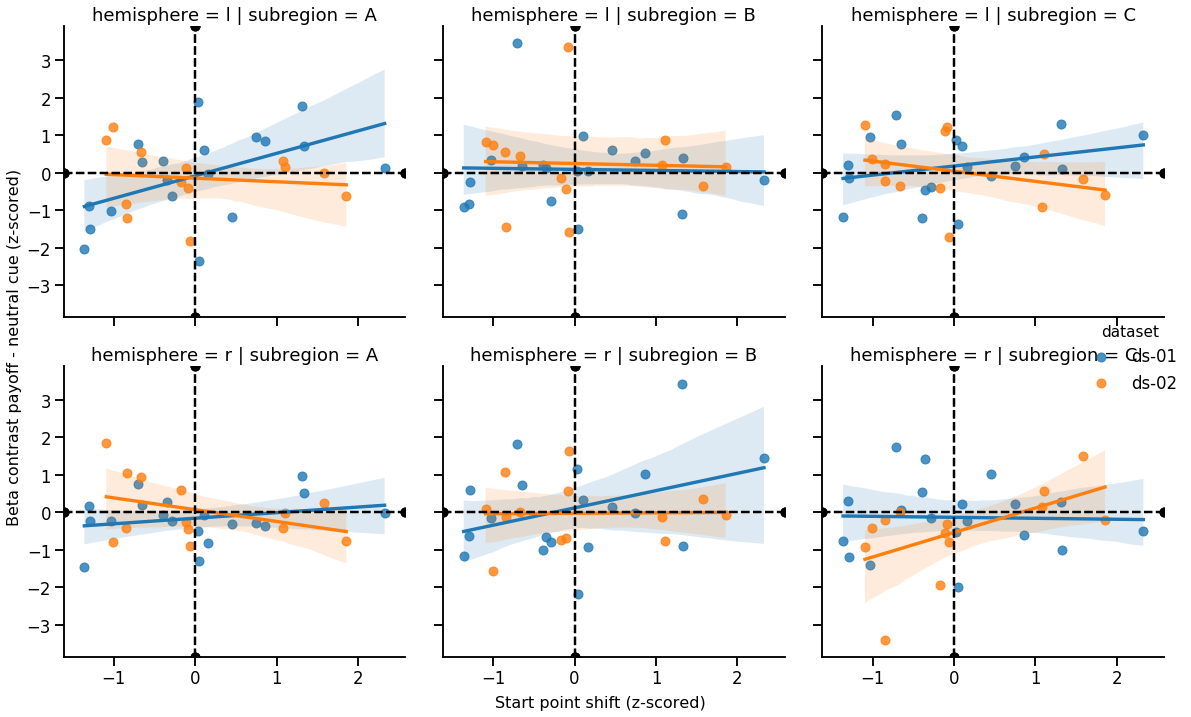

In [8]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias_zscored',
                 y='contrast_zscored', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

In [9]:
# correlation estimates
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'contrast_zscored'], 
                                combined_data.loc[(combined_data.roi==roi), 'zshiftBias'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,r,p,p.fdr
0,signal_l_A,0.281867,0.118070,0.663964
1,signal_l_B,-0.012373,0.946416,0.952412
2,signal_l_C,0.015200,0.934195,0.952412
3,signal_r_A,-0.010986,0.952412,0.952412
4,signal_r_B,0.220896,0.224390,0.663964
5,signal_r_C,0.177184,0.331982,0.663964


In [10]:
%load_ext rpy2.ipython

In [11]:
combined_data.head()

,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,1,signal_l_A,0.148641,ds-01,0.610767,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,A
1,1,signal_l_B,0.209342,ds-01,0.974539,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,B
2,1,signal_l_C,0.166442,ds-01,0.717443,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,C
3,1,signal_r_A,0.033935,ds-01,-0.076653,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,A
4,1,signal_r_B,0.102775,ds-01,0.335896,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,B


In [12]:
%%R -i combined_data
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

bf1 = lmBF(zshiftBias ~ 1 + dataset, data = combined_data, whichRandom='subject')
bf2 = lmBF(zshiftBias ~ 1 + contrast + dataset, data = combined_data, whichRandom='subject')
bf3 = lmBF(zshiftBias ~ 1 + contrast*subregion + dataset, data = combined_data, whichRandom='subject')
print(bf1)         # BF10 = 174.863 --> strong evidence for an effect of dataset on zshifts
print(bf2/bf1)     # BF21 = 0.70864 --> anecdotal evidence against a correlation
print(bf3/bf2)     # BF32 = 0.0036252 --> strong evidence against any differences in correlations between subregions

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "roi". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "dataset". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "hemisphere". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "subregion". Fall back to string conversion. The error is: module 'p

Bayes factor analysis
--------------
[1] 1 + dataset : 160.8085 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast + dataset : 0.6258971 ±0.84%

Against denominator:
  zshiftBias ~ 1 + dataset 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast * subregion + dataset : 0.003910037 ±3.23%

Against denominator:
  zshiftBias ~ 1 + contrast + dataset 
---
Bayes factor type: BFlinearModel, JZS



## Evidence against correlations, evidence against any difference between hemispheres, evidence against any difference between subregions

# Easy vs hard?

In [13]:
betas_easyhard = all_betas.loc[all_betas['event type'].isin(['easy', 'hard'])]

def get_contrast(x):
    return pd.Series({'contrast': x.loc[x['event type'] == 'hard', 'beta'].values[0] - x.loc[x['event type'] == 'easy', 'beta'].values[0]})

beta_contrast = betas_easyhard.groupby(['subject', 'roi'])[['event type', 'beta']].apply(get_contrast)

beta_contrast = beta_contrast.reset_index()
beta_contrast['dataset'] = np.hstack([np.repeat(['ds-01'], 19*6), np.repeat(['ds-02'], 14*6)])
contrast_zscored = beta_contrast.groupby(['dataset'])['contrast'].apply(lambda x: (x-x.mean())/x.std())
beta_contrast['contrast_zscored'] = contrast_zscored
beta_contrast.head()

,subject,roi,contrast,dataset,contrast_zscored
0,1,signal_l_A,0.013394,ds-01,0.188676
1,1,signal_l_B,-0.210553,ds-01,-1.291076
2,1,signal_l_C,-0.338578,ds-01,-2.137019
3,1,signal_r_A,-0.054502,ds-01,-0.259955
4,1,signal_r_B,-0.040659,ds-01,-0.168484


In [14]:
combined_data = pd.merge(beta_contrast.reset_index(), all_params, on=['subject', 'dataset'])
combined_data['hemisphere'] = combined_data['roi'].str.split('_').apply(lambda x: x[1])
combined_data['subregion'] = combined_data['roi'].str.split('_').apply(lambda x: x[2])

Text(0.5, 0, 'Drift rate change (z-scored)')

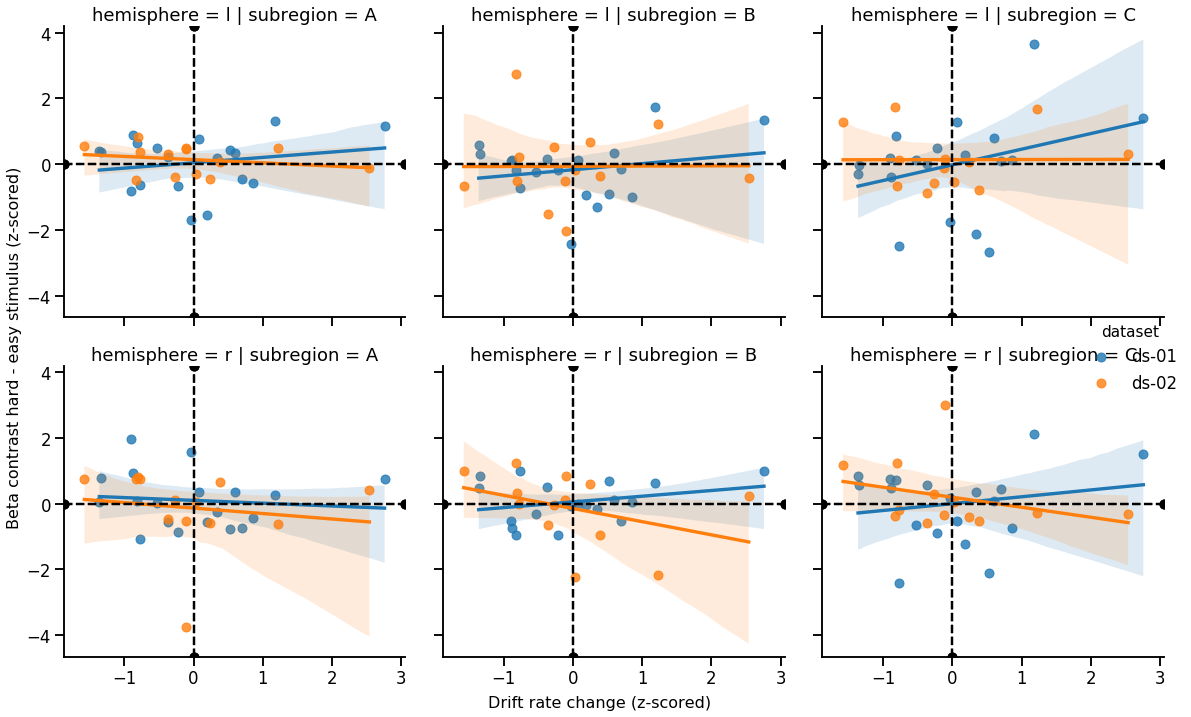

In [15]:
fac = sns.lmplot(x='vshift_zscored',
                 y='contrast_zscored', data=combined_data, 
                 row='hemisphere', col='subregion', hue='dataset', truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast hard - easy stimulus (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Drift rate change (z-scored)', #this is the text in the xlabel
             size=16)

In [16]:
# correlation estimates
results = []
for roi in combined_data.roi.unique():
    print(roi)
    r, p = scipy.stats.pearsonr(combined_data.loc[(combined_data.roi==roi), 'contrast_zscored'], 
                                combined_data.loc[(combined_data.roi==roi), 'vshift_zscored'])
    results.append({'mask': roi, 'r':r, 'p':p})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

signal_l_A
signal_l_B
signal_l_C
signal_r_A
signal_r_B
signal_r_C


,mask,r,p,p.fdr
0,signal_l_A,0.075886,0.679757,0.815896
1,signal_l_B,0.106558,0.561607,0.815896
2,signal_l_C,0.217889,0.230923,0.815896
3,signal_r_A,-0.116458,0.525598,0.815896
4,signal_r_B,-0.075847,0.679914,0.815896
5,signal_r_C,-0.005915,0.974369,0.974369


In [17]:
combined_data.head()

,index,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,0,1,signal_l_A,0.013394,ds-01,0.188676,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,A
1,1,1,signal_l_B,-0.210553,ds-01,-1.291076,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,B
2,2,1,signal_l_C,-0.338578,ds-01,-2.137019,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,l,C
3,3,1,signal_r_A,-0.054502,ds-01,-0.259955,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,A
4,4,1,signal_r_B,-0.040659,ds-01,-0.168484,1.338917,0.200123,0.713663,0.449544,0.026421,0.51354,-0.148044,0.458038,0.103937,0.340401,-0.9251,r,B


In [18]:
combined_data_difficulty = combined_data.copy()

In [19]:
%%R -i combined_data
library(BayesFactor)

combined_data$hemisphere <- factor(combined_data$hemisphere)
combined_data$subregion <- factor(combined_data$subregion)
combined_data$dataset <- factor(combined_data$dataset)
combined_data$subject <- factor(combined_data$subject)

bf1 = lmBF(vshift ~ 1 + dataset, data = combined_data, whichRandom='subject')
bf2 = lmBF(vshift ~ 1 + contrast + dataset, data = combined_data, whichRandom='subject')
bf3 = lmBF(vshift ~ 1 + contrast*subregion + dataset, data = combined_data, whichRandom='subject')
print(bf1)         # BF10 = 3.78*10^16 --> decisive evidence for an effect of dataset on vshifts
print(bf2/bf1)     # BF21 = 0.1704103 --> strong evidence against a correlation between zshifts and beta contrasts
print(bf3/bf2)     # BF32 = 0.004387895 --> decisive evidence against any differences in correlations between subregions

R[write to console]: 0% 10   20   30   40   50   60   70   80   90   100%

R[write to console]: |----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *


Bayes factor analysis
--------------
[1] 1 + dataset : 3.264039e+16 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast + dataset : 0.1689454 ±1.1%

Against denominator:
  vshift ~ 1 + dataset 
---
Bayes factor type: BFlinearModel, JZS

Bayes factor analysis
--------------
[1] 1 + contrast * subregion + dataset : 0.004745064 ±4.15%

Against denominator:
  vshift ~ 1 + contrast + dataset 
---
Bayes factor type: BFlinearModel, JZS



## Again, evidence against differences between subregions

## Figure for paper

Text(0.5, 0, 'Start point shift (z-scored)')

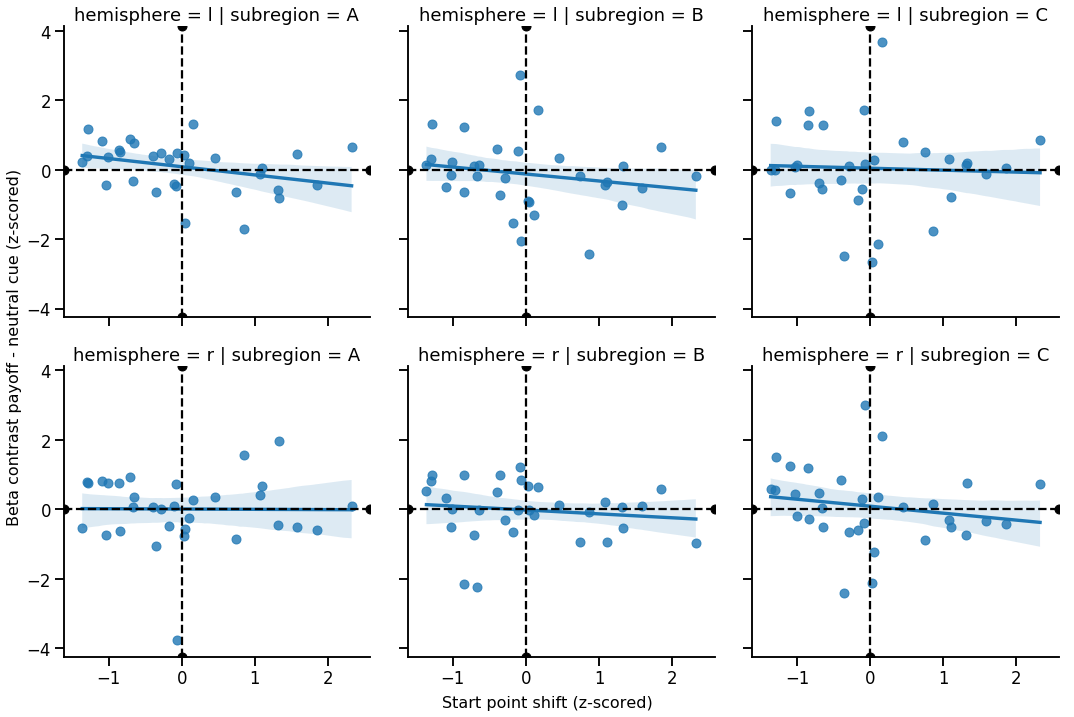

In [20]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias_zscored',
                 y='contrast_zscored', data=combined_data, 
                 row='hemisphere', col='subregion', 
                 #hue='dataset', 
                 truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

In [21]:
combined_data

,index,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,0,1,signal_l_A,0.013394,ds-01,0.188676,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,A
1,1,1,signal_l_B,-0.210553,ds-01,-1.291076,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,B
2,2,1,signal_l_C,-0.338578,ds-01,-2.137019,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,C
3,3,1,signal_r_A,-0.054502,ds-01,-0.259955,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,r,A
4,4,1,signal_r_B,-0.040659,ds-01,-0.168484,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,r,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,193,33,signal_l_B,-0.093156,ds-02,-0.654501,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,l,B
188,194,33,signal_l_C,0.320024,ds-02,1.284793,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,l,C
189,195,33,signal_r_A,0.208031,ds-02,0.759146,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,r,A
190,196,33,signal_r_B,0.257553,ds-02,0.991580,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,r,B


Text(0.5, 0, 'Start point shift (z-scored)')

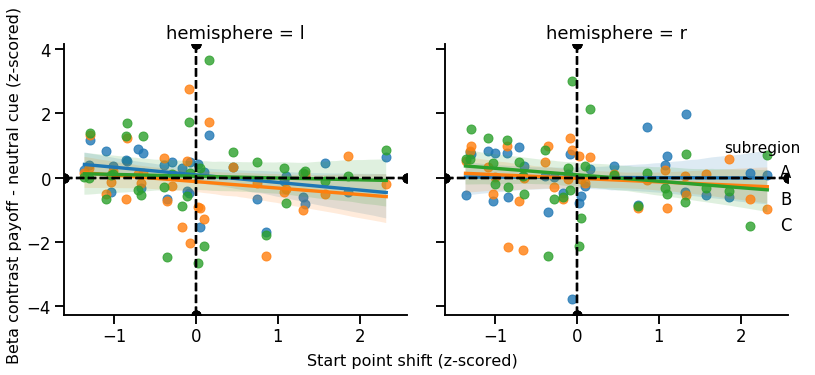

In [22]:
sns.set_context('talk')
fac = sns.lmplot(x='zshiftBias_zscored',
                 y='contrast_zscored', data=combined_data, 
                 col='hemisphere', hue='subregion', 
                 #hue='dataset', 
                 truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=16, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=16)

Text(0.5, 0, 'Start point shift (z-scored)')

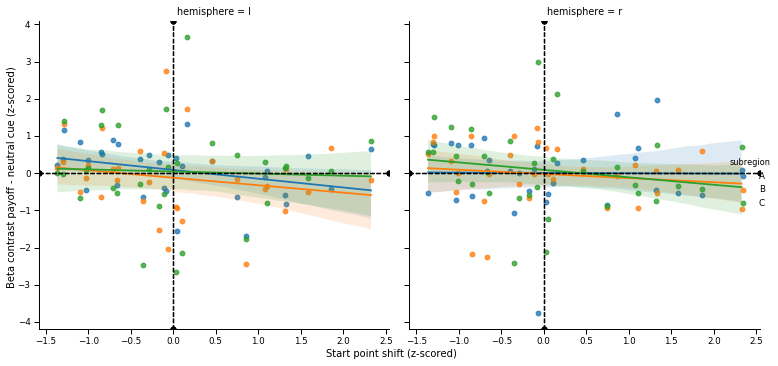

In [23]:
sns.set_context('paper')


fac = sns.lmplot(x='zshiftBias_zscored',
                 y='contrast_zscored', data=combined_data, 
                 col='hemisphere', hue='subregion', 
                 #hue='dataset', 
                 truncate=True)

fac.map(plt.axhline, y=0, c='k', ls='--')
fac.map(plt.axvline, x=0, c='k', ls='--')

fac.fig.text(x=0, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Beta contrast payoff - neutral cue (z-scored)', #this is the text in the ylabel
           size=10, #customize the fontsize if you will
           rotation=90) #vertical text

#overall xlabel
fac.fig.text(x=0.5, y=0, 
             horizontalalignment='center', #make sure it's aligned at center horizontally
             s='Start point shift (z-scored)', #this is the text in the xlabel
             size=10)

In [24]:
combined_data

,index,subject,roi,contrast,dataset,contrast_zscored,a,v.low,v.high,z,zshiftBias,vshift,vshiftBias,t0,zshiftBias_zscored,vshift_zscored,vshiftBias_zscored,hemisphere,subregion
0,0,1,signal_l_A,0.013394,ds-01,0.188676,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,A
1,1,1,signal_l_B,-0.210553,ds-01,-1.291076,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,B
2,2,1,signal_l_C,-0.338578,ds-01,-2.137019,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,l,C
3,3,1,signal_r_A,-0.054502,ds-01,-0.259955,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,r,A
4,4,1,signal_r_B,-0.040659,ds-01,-0.168484,1.338917,0.200123,0.713663,0.449544,0.026421,0.513540,-0.148044,0.458038,0.103937,0.340401,-0.925100,r,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,193,33,signal_l_B,-0.093156,ds-02,-0.654501,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,l,B
188,194,33,signal_l_C,0.320024,ds-02,1.284793,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,l,C
189,195,33,signal_r_A,0.208031,ds-02,0.759146,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,r,A
190,196,33,signal_r_B,0.257553,ds-02,0.991580,1.487337,0.235462,0.409213,0.490805,0.006615,0.173752,0.597671,0.480999,-0.851415,-1.578994,1.860187,r,B


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


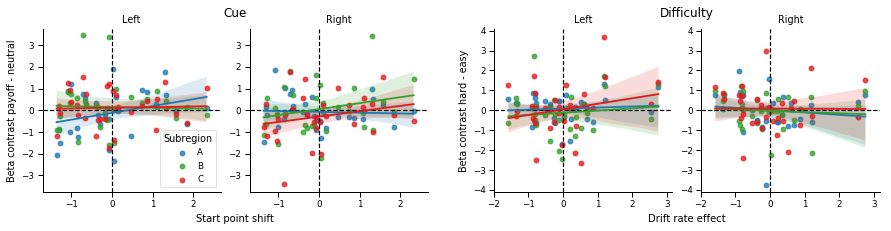

In [25]:
f, ax = plt.subplots(1,5, gridspec_kw={'wspace': 0.2, 'width_ratios': [1,1,.05,1,1]})
for ax_n in [0,1,3,4]:
    ax[ax_n].axhline(y=0, c='k', ls='--')
    ax[ax_n].axvline(x=0, c='k', ls='--')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='l')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[0], label=subregion)
ax[0].set_ylim([-3.75, 3.75])
ax[0].set_title('Left')
ax[0].set_xlabel('')
ax[0].set_ylabel('Beta contrast payoff - neutral')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='r')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1])
ax[1].set_ylim([-3.75, 3.75])
ax[1].set_title('Right')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[3])
ax[3].set_ylim([-4.1, 4.1])
ax[3].set_title('Left')
ax[3].set_ylabel('Beta contrast hard - easy')
ax[3].set_xlabel('')
    
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[4])
ax[4].set_ylim([-4.1, 4.1])
ax[4].set_title('Right')
ax[4].set_ylabel('')
ax[4].set_xlabel('')

## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[j].get_window_extent().x0, ax[j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0,"Start point shift", va="center", ha="center", size=10)
plt.figtext(right_center[0],0,"Drift rate effect", va="center", ha="center", size=10)

sns.despine()
ax[2].axis('off')

ax[0].legend(title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
f.set_size_inches(15,3)

In [128]:
f.savefig('figures/figure5.pdf', bbox_inches='tight')

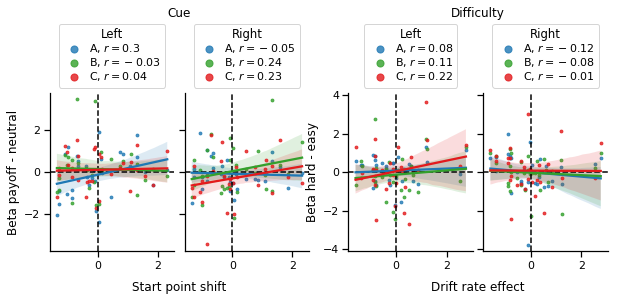

In [26]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

s = 8


f, ax = plt.subplots(2,5, gridspec_kw={'wspace': 0.1, 'height_ratios': [0.2, 0.8], 'width_ratios': [1,1,.15,1,1]}, 
                     figsize=(10,4))
for ax_n in [0,1,3,4]:
    ax[1,ax_n].axhline(y=0, c='k', ls='--')
    ax[1,ax_n].axvline(x=0, c='k', ls='--')
    
r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='l')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,0], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data_cue.loc[(combined_data_cue.hemisphere=='l') & (combined_data_cue.subregion==subregion), 'zshiftBias_zscored'],
                          combined_data_cue.loc[(combined_data_cue.hemisphere=='l') & (combined_data_cue.subregion==subregion), 'contrast_zscored'])[0,1])
ax[1,0].set_ylim([-3.75, 3.75])
# ax[0,0].set_title('Left')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Beta payoff - neutral')
h, l = ax[1,0].get_legend_handles_labels()
leg = ax[1,0].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Left',  labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='r')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,1], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data_cue.loc[(combined_data_cue.hemisphere=='r') & (combined_data_cue.subregion==subregion), 'zshiftBias_zscored'],
                          combined_data_cue.loc[(combined_data_cue.hemisphere=='r') & (combined_data_cue.subregion==subregion), 'contrast_zscored'])[0,1])

ax[1,1].set_ylim([-3.75, 3.75])
# ax[0,1].set_title('Right')
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
h, l = ax[1,1].get_legend_handles_labels()
leg = ax[1,1].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Right', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,3], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion), 'vshift_zscored'],
                          combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion), 'contrast_zscored'])[0,1])

ax[1,3].set_ylim([-4.1, 4.1])
# ax[0,3].set_title('Left')
ax[1,3].set_ylabel('Beta hard - easy')
ax[1,3].set_xlabel('')
h, l = ax[1,3].get_legend_handles_labels()
leg = ax[1,3].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                 'B, $r = ' + str(np.round(r_[1],2))+'$',
                 'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Left', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])


r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[1,4], label=subregion, scatter_kws={'s': s})
    r_.append(np.corrcoef(combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion), 'vshift_zscored'],
                          combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion), 'contrast_zscored'])[0,1])

ax[1,4].set_ylim([-4.1, 4.1])
# ax[0,4].set_title('Right')
ax[1,4].set_ylabel('')
ax[1,4].set_xlabel('')
h, l = ax[1,4].get_legend_handles_labels()
leg = ax[1,4].legend(h, ['A, $r = ' + str(np.round(r_[0],2))+'$',
                   'B, $r = ' + str(np.round(r_[1],2))+'$',
                   'C, $r = ' + str(np.round(r_[2],2))+'$'], loc='lower center', bbox_to_anchor=(0.5,1.), 
                     title='Right', labelspacing=0.1, handletextpad=0.35)
plt.setp(leg.get_title(),fontsize='small')
for handle in leg.legendHandles:
    handle.set_sizes([50.0])

ax[1,1].tick_params(labelleft=False)
ax[1,4].tick_params(labelleft=False)


## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[1,j].get_window_extent().x0, ax[1,j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0,"Start point shift", va="center", ha="center", size=12)
plt.figtext(right_center[0],0,"Drift rate effect", va="center", ha="center", size=12)

sns.despine()
ax[1,2].axis('off')
for ax_n in [0,1,2,3,4]:
    ax[0,ax_n].axis('off')
    
#h, l = ax[1,0].get_legend_handles_labels()
#ax[1,0].legend(h, ['A test', 'B test', 'C'], title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[1,0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
#f.set_size_inches(15,3)

In [214]:
f.savefig('figures/figure5_size.pdf', bbox_inches='tight')

In [ ]:
## just by row?

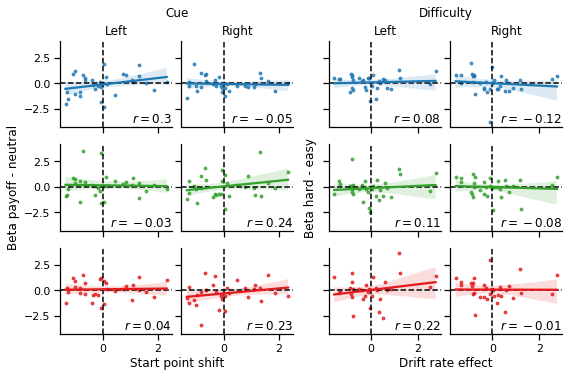

In [87]:
sns.set_context('notebook')
font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

s = 8
f, ax = plt.subplots(3,5, sharey=True, gridspec_kw={'wspace': 0.1, #'height_ratios': [0.2, 0.8], 
                                                    'width_ratios': [1,1,.15,1,1]}, 
                     figsize=(9,.9*6))
for ax_n in [0,1,3,4]:
    for ax_y in [0,1,2]:
        ax[ax_y,ax_n].axhline(y=0, c='k', ls='--')
        ax[ax_y,ax_n].axvline(x=0, c='k', ls='--')
    
r_ = []
for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data_cue.loc[(combined_data_cue.hemisphere=='l') & (combined_data_cue.subregion==subregion), 'zshiftBias_zscored'],
                     combined_data_cue.loc[(combined_data_cue.hemisphere=='l') & (combined_data_cue.subregion==subregion), 'contrast_zscored'])[0,1]
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='l')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,0], # label='$r = ' + str(np.round(r_,2)) + '$', 
                scatter_kws={'s': s})
    ax[i,0].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,0].transAxes, horizontalAlignment='right')
    
ax[0,0].set_title('Left')
_ = [ax[i,0].set_xlabel('') for i in [0,1,2]]
ax[0,0].set_ylabel('')
ax[1,0].set_ylabel('Beta payoff - neutral')
ax[2,0].set_ylabel('')
_ = [ax[i,0].set_xticklabels([]) for i in [0,1]]

for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data_cue.loc[(combined_data_cue.hemisphere=='r') & (combined_data_cue.subregion==subregion), 'zshiftBias_zscored'],
                     combined_data_cue.loc[(combined_data_cue.hemisphere=='r') & (combined_data_cue.subregion==subregion), 'contrast_zscored'])[0,1]
    sns.regplot(x='zshiftBias_zscored', y='contrast_zscored', 
                data=combined_data_cue.loc[(combined_data_cue.hemisphere=='r')&(combined_data_cue.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,1], label='$r = ' + str(np.round(r_,2)) + '$', 
                scatter_kws={'s': s})
    ax[i,1].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,1].transAxes, horizontalAlignment='right')

ax[0,1].set_title('Right')
_ = [ax[i,1].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,1].set_xticklabels([]) for i in [0,1]]


for i, subregion in enumerate(['A', 'B', 'C']):
    r_ = np.corrcoef(combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion), 'vshift_zscored'],
                     combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion), 'contrast_zscored'])[0,1]
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='l')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,3], label='$r = ' + str(np.round(r_,2)) + '$',
                scatter_kws={'s': s})
    ax[i,3].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,3].transAxes, horizontalAlignment='right')
#    ax[i,3].legend(loc='lower right', labelspacing=0.1, handletextpad=0.35)

ax[0,3].set_title('Left')
_ = [ax[i,3].set_xlabel('') for i in [0,1,2]]
ax[0,3].set_ylabel('')
ax[1,3].set_ylabel('Beta hard - easy', labelpad=12)
ax[2,3].set_ylabel('')
_ = [ax[i,3].set_xticklabels([]) for i in [0,1]]


for i, subregion in enumerate(['A', 'B', 'C']):
    r_ =  np.corrcoef(combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion), 'vshift_zscored'],
                      combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion), 'contrast_zscored'])[0,1]
    sns.regplot(x='vshift_zscored', y='contrast_zscored', 
                data=combined_data_difficulty.loc[(combined_data_difficulty.hemisphere=='r')&(combined_data_difficulty.subregion==subregion)], 
                truncate=True, color=sns.color_palette("Paired")[i*2+1],
                ax=ax[i,4], label='$r = ' + str(np.round(r_,2)) + '$',
                scatter_kws={'s': s})
    ax[i,4].text(x=1, y=0.05, s='$r = ' + str(np.round(r_,2)) + '$', transform=ax[i,4].transAxes, horizontalAlignment='right')
#    ax[i,4].legend(loc='lower right', labelspacing=0.1, handletextpad=0.35)

ax[0,4].set_title('Right')
_ = [ax[i,4].set_ylabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xlabel('') for i in [0,1,2]]
_ = [ax[i,4].set_xticklabels([]) for i in [0,1]]


## subplots title: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
ext = []
#loop over the columns (j) and rows(i) to populate subplots
for j in range(5):
#     for i in range(1):
#         axes[i,j].scatter(x, y[:,4*i+j], c=colors[j], s=25) 
#     # each axes in the top row gets its own axes title
#     axes[0,j].set_title('title {}'.format(j+1))
    # save the axes bounding boxes for later use
    ext.append([ax[1,j].get_window_extent().x0, ax[1,j].get_window_extent().width ])

# from the axes bounding boxes calculate the optimal position of the column spanning title
#f.subplots_adjust(top=0.85)
inv = f.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],0.95,"Cue", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.95,"Difficulty", va="center", ha="center", size=12)

# x-axis labels
plt.figtext(left_center[0],0.05,"Start point shift", va="center", ha="center", size=12)
plt.figtext(right_center[0],0.05,"Drift rate effect", va="center", ha="center", size=12)

sns.despine()
ax[0,2].axis('off')
ax[1,2].axis('off')
ax[2,2].axis('off')
# for ax_n in [0,1,2,3,4]:
#     ax[0,ax_n].axis('off')
    
#h, l = ax[1,0].get_legend_handles_labels()
#ax[1,0].legend(h, ['A test', 'B test', 'C'], title='Subregion')
#plt.subplots_adjust(right=.95)
#h, l = ax[1,0].get_legend_handles_labels()
#f.legend(h, l, loc='center right', title='Subregion')
f.tight_layout()
f.savefig('./figures/figure5_3x4.pdf', bbox_inches='tight')
# f.set_size_inches(15,6)